In [1]:
import csv
import pandas as pd
import torch
import numpy as np

In [3]:
!unzip -u '/content/drive/MyDrive/CSE4238/Assignment2/Dataset A.zip'

Streaming output truncated to the last 5000 lines.
  inflating: training-a/a14702.png   
  inflating: training-a/a14703.png   
  inflating: training-a/a14704.png   
  inflating: training-a/a14705.png   
  inflating: training-a/a14706.png   
  inflating: training-a/a14707.png   
  inflating: training-a/a14708.png   
  inflating: training-a/a14709.png   
  inflating: training-a/a14710.png   
  inflating: training-a/a14711.png   
  inflating: training-a/a14712.png   
  inflating: training-a/a14713.png   
  inflating: training-a/a14714.png   
  inflating: training-a/a14715.png   
  inflating: training-a/a14716.png   
  inflating: training-a/a14717.png   
  inflating: training-a/a14718.png   
  inflating: training-a/a14719.png   
  inflating: training-a/a14720.png   
  inflating: training-a/a14721.png   
  inflating: training-a/a14722.png   
  inflating: training-a/a14723.png   
  inflating: training-a/a14724.png   
  inflating: training-a/a14725.png   
  inflating: training-a/a14726.png   

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df=pd.read_csv('/content/drive/MyDrive/CSE4238/Assignment2/training-a.csv')

In [5]:
df.head()

,filename,original filename,scanid,digit,database name original,contributing team,database name
0,a00000.png,Scan_58_digit_5_num_8.png,58,5,BHDDB,Buet_Broncos,training-a
1,a00001.png,Scan_73_digit_3_num_5.png,73,3,BHDDB,Buet_Broncos,training-a
2,a00002.png,Scan_18_digit_1_num_3.png,18,1,BHDDB,Buet_Broncos,training-a
3,a00003.png,Scan_166_digit_7_num_3.png,166,7,BHDDB,Buet_Broncos,training-a
4,a00004.png,Scan_108_digit_0_num_1.png,108,0,BHDDB,Buet_Broncos,training-a


In [6]:
df.drop(df.columns[[1, 2, 4,5,6]], axis = 1, inplace = True) 

In [7]:
df.head()

,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0


In [8]:
df['digit'].unique()

array([5, 3, 1, 7, 0, 4, 9, 8, 2, 6])

In [9]:
df['digit'].value_counts()

2    1984
6    1983
4    1982
3    1976
0    1975
5    1965
9    1964
1    1963
7    1960
8    1950
Name: digit, dtype: int64

In [10]:
import torch
import cv2
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import torch.nn.functional as F
from PIL import ImageFile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import torch.nn as nn
import torch.nn.functional as f
from skimage import io
from torch.utils.data import (
    Dataset,
    DataLoader,
) 

In [11]:
img = cv2.imread('/content/training-a/a00000.png')

In [12]:
img.shape

(180, 180, 3)

In [13]:
IMAGE_SIZE = 40 
transform = transforms.Compose([
                                transforms.ToPILImage(),
                                # transforms.Grayscale(),
                                torchvision.transforms.ColorJitter(brightness=0.4,saturation=0.4,contrast=0.4,hue=0.4),
                                transforms.RandomRotation(20,expand=True), 
                                transforms.Resize(IMAGE_SIZE),  ## image resize
                                transforms.CenterCrop(IMAGE_SIZE), ## image center crop
                                transforms.ToTensor(), ## array converted into torch tensor and then divided by 255 (1.0/255)
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                
                               ])

In [14]:
class digit_Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=True):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = cv2.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 3]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [16]:
dataset =digit_Dataset(
    csv_file='/content/drive/MyDrive/CSE4238/Assignment2/training-a.csv',
    root_dir='/content/training-a',
    transform=transform,
)

In [17]:
train_set, test_set = torch.utils.data.random_split(dataset, [15762, 3940])
train_loader = DataLoader(dataset=train_set, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=100, shuffle=True)

In [18]:
len(train_loader)

158

In [19]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [20]:
data_iter = iter(train_loader)
images, labels = data_iter.next()
images.shape

torch.Size([100, 3, 40, 40])

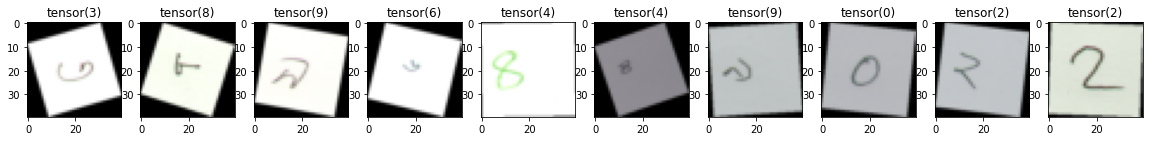

In [21]:
dataiter = iter(train_loader)
plt.subplots(figsize=(20, 40))
for i in range(10):
    plt.subplot(10/2, 10,i+1)
    img = images[i].detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5]) 
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.title(labels[i])
    # print(img.shape)
    plt.imshow(img)
plt.show()

In [22]:
class Net(nn.Module): # Module is library package
    
    def __init__(self):
        super().__init__()
        
        self.fc1=nn.Linear(3*40 * 40, 1000)  #flatten the image 
        self.fc2=nn.Linear(1000,1000)
        self.fc3=nn.Linear(1000,1000)
        self.fc4=nn.Linear(1000,1000)  
        self.fc5=nn.Linear(1000,1000)
        self.fc6=nn.Linear(1000,10)
        
    def forward(self,x): # pass the data
        
        x=f.relu(self.fc1(x))
        x=f.relu(self.fc2(x))
        x=f.relu(self.fc3(x))
        x=f.relu(self.fc4(x))
        x=f.relu(self.fc5(x))
        
        x=self.fc6(x)
        
        return x
               

net=Net()
print(net)

Net(
  (fc1): Linear(in_features=4800, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=1000, bias=True)
  (fc5): Linear(in_features=1000, out_features=1000, bias=True)
  (fc6): Linear(in_features=1000, out_features=10, bias=True)
)


In [23]:
net.cuda()

Net(
  (fc1): Linear(in_features=4800, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=1000, bias=True)
  (fc5): Linear(in_features=1000, out_features=1000, bias=True)
  (fc6): Linear(in_features=1000, out_features=10, bias=True)
)

In [24]:
optimizer =  optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
 
criterion = torch.nn.CrossEntropyLoss()

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [26]:
device

device(type='cuda', index=0)

In [ ]:
Path='./net_final.pth'
traininglosses = []
trainingaccuracy = []
testinglosses = []
testaccuracy = []
totalsteps = []
epochs = 317
steps = 0
running_loss = 0
print_every = 500

#epoch iteration
for epoch in range(epochs):
    accuracy = 0
    for inputs, labels in train_loader:
        net.train()
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() 
        
        logps = net.forward(inputs.view(-1,3*40*40))
        loss = criterion(logps, labels)
        loss.backward() 
        optimizer.step() 
 
        #Calculate traning accuracy
        pred = torch.argmax(logps, dim=1)
        correct = pred.eq(labels)
       
        running_loss += loss.item()
        accuracy += torch.mean(correct.float())
        
        if steps % print_every == 0:
            after_train_accuracy=accuracy/print_every
            test_loss = 0
            accuracy = 0
            net.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = net.forward(inputs.view(-1,3*40*40))
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    pred = torch.argmax(logps, dim=1)
                    correct = pred.eq(labels)
                    accuracy += torch.mean(correct.float())
            
            traininglosses.append(running_loss/print_every)
            trainingaccuracy.append(after_train_accuracy)
            testinglosses.append(test_loss/len(test_loader))
            testaccuracy.append(accuracy/len(test_loader))
            totalsteps.append(steps)
            print(f"Device {device} "
                  f"Epoch {epoch+1}/{epochs} "
                  f"Steps {steps} "
                  f"Train Loss: {running_loss/print_every:f} "
                  f"Train Accuracy: {after_train_accuracy:f} "
                  f"Test Loss: {test_loss/len(test_loader):f} "
                  f"Test Accuracy: {accuracy/len(test_loader):f}")
            running_loss = 0
            accuracy = 0
            net.train()
print('Training finish')
torch.save(net.state_dict(), Path)

Device cuda:0 Epoch 4/317 Steps 500 Train Loss: 2.302390 Train Accuracy: 0.005460 Test Loss: 2.300959 Test Accuracy: 0.107375
Device cuda:0 Epoch 7/317 Steps 1000 Train Loss: 2.299017 Train Accuracy: 0.012180 Test Loss: 2.292658 Test Accuracy: 0.122125
Device cuda:0 Epoch 10/317 Steps 1500 Train Loss: 2.249007 Train Accuracy: 0.027620 Test Loss: 2.201054 Test Accuracy: 0.176375
Device cuda:0 Epoch 13/317 Steps 2000 Train Loss: 2.132927 Train Accuracy: 0.050260 Test Loss: 2.076011 Test Accuracy: 0.276000
Device cuda:0 Epoch 16/317 Steps 2500 Train Loss: 2.038616 Train Accuracy: 0.069340 Test Loss: 1.982399 Test Accuracy: 0.273500
Device cuda:0 Epoch 19/317 Steps 3000 Train Loss: 1.922035 Train Accuracy: 0.101880 Test Loss: 1.863235 Test Accuracy: 0.336000
Device cuda:0 Epoch 23/317 Steps 3500 Train Loss: 1.788686 Train Accuracy: 0.018740 Test Loss: 1.644852 Test Accuracy: 0.418875
Device cuda:0 Epoch 26/317 Steps 4000 Train Loss: 1.660961 Train Accuracy: 0.045240 Test Loss: 1.680937 Tes